In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [147]:
df = pd.read_excel('test_data_1.xlsx')

In [148]:
df.head()

,client_id,order_date,order_price,city_id
0,43000,2022-01-08 00:00:00,9250,2
1,43001,2022-01-14 00:00:00,8000,3
2,43002,2022-01-03 00:00:00,4550,1
3,43003,2022-01-14 00:00:00,3550,2
4,43004,2022-01-26 00:00:00,7700,3


In [141]:
len(df), len(df['client_id'].unique())

(10926, 8925)

Видим что в целом не много людей вернулось (всего около 2000 повторных заказов), поэтому retention будем считать по месяцам

In [161]:
def calculate_retention(data):
    df = data.copy()
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['order_month'] = df['order_date'].dt.to_period('M')

    first_orders = df.groupby('client_id')['order_date'].min().reset_index()
    first_orders.columns = ['client_id', 'first_order_date']
    first_orders['cohort_month'] = first_orders['first_order_date'].dt.to_period('M')
    df = pd.merge(df, first_orders, on='client_id')

    df['months_since_first_order'] = ((df['order_date'].dt.year - df['first_order_date'].dt.year) * 12 +
                                  df['order_date'].dt.month - df['first_order_date'].dt.month)

    cohort_data = df.groupby(['cohort_month', 'months_since_first_order'])['client_id'].nunique().reset_index()
    cohort_pivot = cohort_data.pivot_table(index='cohort_month', columns='months_since_first_order', values='client_id')

    cohort_size = cohort_pivot.iloc[:, 0]
    retention = cohort_pivot.divide(cohort_size, axis=0).fillna(0)
    retention[0] *= 0

    retention_values = retention[0].values

    for i in range(1, len(retention.columns)):
        retention_values += np.concatenate([retention[i].values[-i:], retention[i].values[:-i]])

    return retention[0].index.strftime('%b'), retention_values * 100

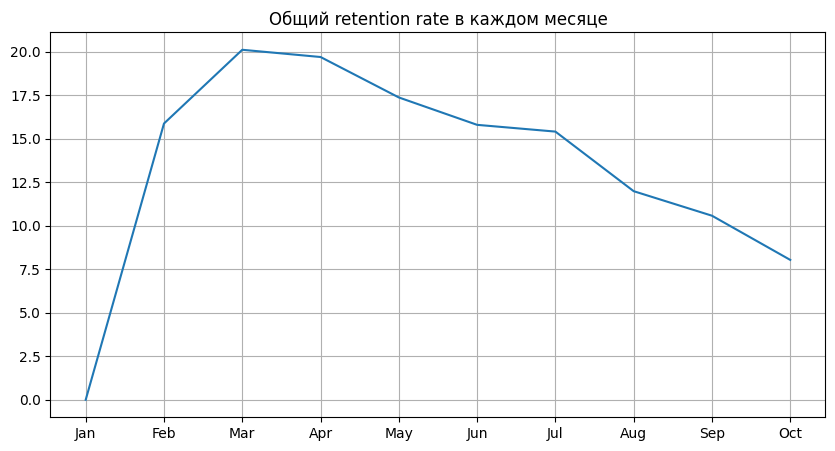

In [162]:
plt.figure(figsize=(10,5))
plt.title('Общий retention rate в каждом месяце')
plt.plot(*calculate_retention(df))
plt.grid()
plt.show()

In [163]:
df.city_id.unique()

array([2, 3, 1])

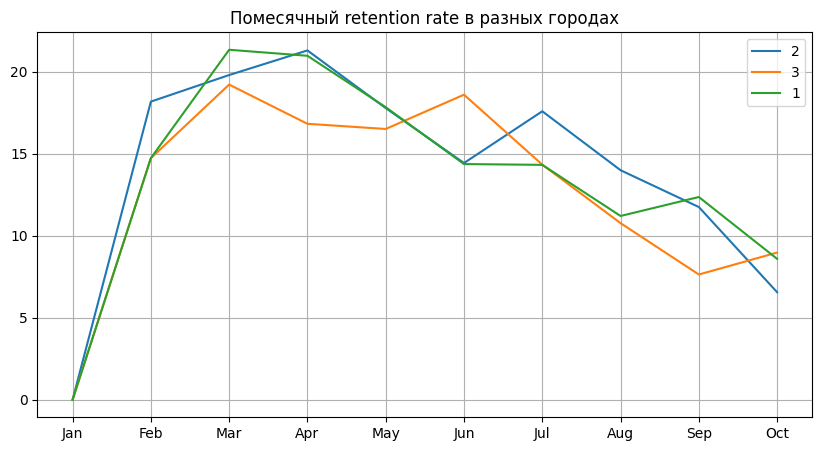

In [164]:
plt.figure(figsize=(10,5))
plt.title('Помесячный retention rate в разных городах')
for i in df.city_id.unique():
    plt.plot(*calculate_retention(df.loc[df.city_id == i]), label=i)
plt.grid()
plt.legend()
plt.show()

Видим что в разных городах тенденция примерно одинаковая

Также можно посмотреть retention в зависимости от ценового диапазона.